# Container Metrics Analysis - Exploratory Analysis

**Project**: Predictive Autoscaling  
**Objective**: Analyze collected metrics for patterns and prepare for ML model training

## Overview
This notebook performs exploratory analysis on container metrics collected from prometheus server from a kubernetes pods running in different clusters.

### Metrics Collected:
1. **CPU Usage** - Container CPU utilization
2. **Memory Usage** - Container memory consumption
3. **Network Traffic** - RX/TX bytes per second
4. **Disk Read/Write Rates** - Application disk read/write rates

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from IPython.display import display, HTML
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, LinearColorMapper, ColorBar, BasicTicker
from bokeh.transform import transform
from bokeh.palettes import RdYlBu11
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource, Legend, LegendItem
from bokeh.layouts import column

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✅ Libraries imported successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis date: 2025-12-24 15:51:01


## Data Loading

Load the most recent metrics export from the `data/raw/metrics` directory.

In [2]:
def get_latest_metric_files(file_paths):
    """
    Parse metric file paths and return the latest file for each metric type.
    Args:
        file_paths: List of file paths with format: metric_name_YYYYMMDD_HHMMSS.csv
    Returns:
        Dict mapping metric_name to the latest file path
    """
    metric_files = defaultdict(list)
    for file_path in file_paths:
        path = Path(file_path)
        filename = path.stem  # removes .csv extension
        # Split by underscore and find the timestamp parts
        parts = filename.split('_')
        # Last two parts should be date and time
        if len(parts) >= 2:
            try:
                date_str = parts[-2]
                time_str = parts[-1]
                timestamp = datetime.strptime(f"{date_str}_{time_str}", "%Y%m%d_%H%M%S")
                # Everything before the timestamp is the metric name
                metric_name = '_'.join(parts[:-2])
                metric_files[metric_name].append((timestamp, file_path))
            except ValueError:
                print(f"Warning: Could not parse timestamp from {filename}")
                continue
    # Get the latest file for each metric
    latest_files = {}
    for metric_name, files in metric_files.items():
        # Sort by timestamp and pick the latest
        latest = max(files, key=lambda x: x[0])
        latest_files[metric_name] = latest[1]
    return latest_files


In [3]:
# Example usage:
files = [
    '../data/raw/metrics/container_network_transmit_rate_20251219_063035.csv',
    '../data/raw/metrics/container_cpu_rate_20251224_001604.csv',
    '../data/raw/metrics/container_cpu_rate_20251219_062204.csv',
    # ... rest of your files
]

latest = get_latest_metric_files(files)
for metric, path in sorted(latest.items()):
    print(f"{metric}: {path}")

container_cpu_rate: ../data/raw/metrics/container_cpu_rate_20251224_001604.csv
container_network_transmit_rate: ../data/raw/metrics/container_network_transmit_rate_20251219_063035.csv


In [4]:
# Find the most recent metrics file
data_dir = '../data/raw/metrics'
metrics_files = glob.glob(os.path.join(data_dir, 'container_*.csv'))

DATAFRAMES = {}

if not metrics_files:
    print("❌ No metrics files found!")
else:
    # Get the most recent file
    print(f"📁 Loading Latest Metrics...")
    latest_metric_files = get_latest_metric_files(metrics_files)

    # Load data
    for container_metric, filepath in latest_metric_files.items():
        df = pd.read_csv(filepath)
        metric = container_metric.removeprefix('container_')
        print(f"{metric} Loaded...")

        # Convert timestamp to datetime & sort
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)

        DATAFRAMES[metric] = df

📁 Loading Latest Metrics...
network_transmit_rate Loaded...
cpu_rate Loaded...
fs_writes_rate Loaded...
memory_usage Loaded...
network_receive_rate Loaded...
fs_reads_rate Loaded...


In [12]:
# ============================================================================
# EFFICIENT DATASET SUMMARY TABLE
# ============================================================================

# MAIN SUMMARY TABLE
print("\\n" + "="*140)
print("📊 DATASET SUMMARY - Compact Overview")
print("="*140)

summary_data = []
for dataset_name, df in DATAFRAMES.items():
    summary_data.append({
        'Dataset': dataset_name,
        'Rows': f"{len(df):,}",
        'Cols': df.shape[1],
        'Columns': ', '.join(df.columns.tolist())
    })

summary_df = pd.DataFrame(summary_data)
display(HTML(summary_df.to_html(index=False)))

\n============================================================================================================================================
📊 DATASET SUMMARY - Compact Overview


Dataset,Rows,Cols,Columns
network_transmit_rate,"191,152",4,"timestamp, container_labels, value, container_id"
cpu_rate,"640,355",4,"timestamp, container_labels, value, container_id"
fs_writes_rate,"516,367",4,"timestamp, container_labels, value, container_id"
memory_usage,"649,640",4,"timestamp, container_labels, value, container_id"
network_receive_rate,"191,152",4,"timestamp, container_labels, value, container_id"
fs_reads_rate,"516,367",4,"timestamp, container_labels, value, container_id"


In [16]:
# Check Sample Data in columns:
DATAFRAMES['network_transmit_rate'].sample(3)

,timestamp,container_labels,value,container_id
161013,2025-12-23 20:06:29,"container=netd-metrics-collector,cpu=total,end...",0.0001,/kubepods.slice/kubepods-burstable.slice/kubep...
305084,2025-12-23 21:21:29,"container=csi-driver-registrar,cpu=total,endpo...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
433708,2025-12-23 22:28:29,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...


In [17]:
DATAFRAMES['cpu_rate'].sample(3)

,timestamp,container_labels,value,container_id
53896,2025-12-23 19:10:44,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
54280,2025-12-23 19:10:59,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-besteffort.slice/kube...
466631,2025-12-23 22:45:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0187,/kubepods.slice/kubepods-burstable.slice/kubep...


In [18]:
DATAFRAMES['memory_usage'].sample(3)

,timestamp,container_labels,value,container_id
452155,2025-12-23 22:34:44,"container=store-gateway,endpoint=https-metrics...",124727296.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
394742,2025-12-23 22:05:29,"endpoint=https-metrics,metrics_path=/metrics/c...",106594304.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
129193,2025-12-23 19:48:59,"container=fluentbit-gke,endpoint=https-metrics...",34131968.0000,/kubepods.slice/kubepods-burstable.slice/kubep...


## Data Exploration (CPU Rate)

In [57]:
# Display basic information
df = DATAFRAMES['cpu_rate']
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

print("\n📋 Column Names:")
print(df.columns.tolist())

print("\n📊 Data Types:")
print(df.dtypes)

print("\n📈 Basic Statistics:")
print(df.describe())

print("\n🔍 First Few Rows:")
display(df.head(10))

print("\n🔍 Sample Data:")
display(df.sample(10))

DATASET OVERVIEW

📋 Column Names:
['timestamp', 'container_labels', 'value', 'container_id']

📊 Data Types:
timestamp           datetime64[ns]
container_labels            object
value                      float64
container_id                object
dtype: object

📈 Basic Statistics:
                           timestamp       value
count                         640355 640355.0000
mean   2025-12-23 21:29:26.129841664      0.0150
min              2025-12-23 18:42:44      0.0000
25%              2025-12-23 20:05:59      0.0000
50%              2025-12-23 21:29:29      0.0004
75%              2025-12-23 22:52:59      0.0031
max              2025-12-24 00:15:59      2.0867
std                              NaN      0.0874

🔍 First Few Rows:


,timestamp,container_labels,value,container_id
0,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0006,/kubepods.slice/kubepods-burstable.slice/kubep...
1,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
2,2025-12-23 18:42:44,"container=autoscaler,cpu=total,endpoint=https-...",0.0003,/kubepods.slice/kubepods-burstable.slice/kubep...
3,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0373,/kubepods.slice/kubepods-burstable.slice/kubep...
4,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0052,/kubepods.slice/kubepods-burstable.slice/kubep...
5,2025-12-23 18:42:44,"container=netd-metrics-collector,cpu=total,end...",0.0002,/kubepods.slice/kubepods-burstable.slice/kubep...
6,2025-12-23 18:42:44,"container=fluentbit-metrics-collector,cpu=tota...",0.0006,/kubepods.slice/kubepods-burstable.slice/kubep...
7,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0024,/kubepods.slice/kubepods-burstable.slice/kubep...
8,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0110,/kubepods.slice/kubepods-burstable.slice/kubep...
9,2025-12-23 18:42:44,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0001,/kubepods.slice/kubepods-burstable.slice/kubep...



🔍 Sample Data:


,timestamp,container_labels,value,container_id
334493,2025-12-23 21:36:59,"container=istio-proxy,cpu=total,endpoint=https...",0.0040,/kubepods.slice/kubepods-burstable.slice/kubep...
435090,2025-12-23 22:29:14,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
177889,2025-12-23 20:15:14,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0004,/kubepods.slice/kubepods-besteffort.slice/kube...
627468,2025-12-24 00:09:29,"container=mdp-controller,cpu=total,endpoint=ht...",0.0021,/kubepods.slice/kubepods-burstable.slice/kubep...
156525,2025-12-23 20:04:14,"cpu=total,endpoint=https-metrics,metrics_path=...",0.0042,/kubepods.slice/kubepods-burstable.slice/kubep...
244088,2025-12-23 20:49:44,"cpu=total,endpoint=https-metrics,image=gke.gcr...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
38256,2025-12-23 19:02:44,"container=alertmanager,cpu=total,endpoint=http...",0.0005,/kubepods.slice/kubepods-burstable.slice/kubep...
47035,2025-12-23 19:06:59,"container=kubectl,cpu=total,endpoint=https-met...",0.0000,/kubepods.slice/kubepods-burstable.slice/kubep...
382290,2025-12-23 22:01:59,"container=event-exporter,cpu=total,endpoint=ht...",0.0008,/kubepods.slice/kubepods-burstable.slice/kubep...
172685,2025-12-23 20:12:29,"container=ingester,cpu=total,endpoint=https-me...",0.1388,/kubepods.slice/kubepods-burstable.slice/kubep...


In [21]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES")
print("=" * 80)

missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✅ No missing values!")

# Here some metrics don't use or won't have a certain field especially Label.
# So the logic should be made dynamic to take that into accout e.g A CPU or Memory based metric might not have method label as that is valid for network metrics only
# Create a metric : valid columns mapping

MISSING VALUES
✅ No missing values!


In [50]:
# Check a specific duplicate case
for idx, metric in enumerate(DATAFRAMES):
    metric_data = DATAFRAMES[metric].drop(columns=['container_labels']).copy()
    
    # Show duplicate count distribution
    agg = metric_data.groupby(['timestamp', 'container_id']).size()
    print(f"\n{metric} - Duplicate counts: min={agg.min()}, max={agg.max()}, mean={agg.mean():.2f}")
    
    # Get a sample with duplicates (find timestamp+container with max duplicates)
    max_dup_idx = agg.idxmax()  # Returns (timestamp, container_id) with most duplicates
    
    sample = metric_data[
        (metric_data['timestamp'] == max_dup_idx[0]) & 
        (metric_data['container_id'] == max_dup_idx[1])
    ].copy()
    
    # Shorten container_id for display
    sample['container_id_short'] = sample['container_id'].str.split('/').str[-1].str[:42] + '...'
    
    print(f"\n{metric} - Sample with {len(sample)} duplicates:")
    print(sample[['timestamp', 'container_id_short', 'value']].to_string(index=False))


network_transmit_rate - Duplicate counts: min=1, max=4, mean=1.01

network_transmit_rate - Sample with 4 duplicates:
          timestamp                            container_id_short     value
2025-12-23 19:42:44 cri-containerd-dc73753d8adfaa881197236cee6...    0.0000
2025-12-23 19:42:44 cri-containerd-dc73753d8adfaa881197236cee6... 1830.8012
2025-12-23 19:42:44 cri-containerd-dc73753d8adfaa881197236cee6...    0.0000
2025-12-23 19:42:44 cri-containerd-dc73753d8adfaa881197236cee6... 1830.8012

cpu_rate - Duplicate counts: min=1, max=2, mean=1.00

cpu_rate - Sample with 2 duplicates:
          timestamp                            container_id_short  value
2025-12-23 19:42:44 kubepods-besteffort-pod02f4d62d_1921_414d_... 0.0020
2025-12-23 19:42:44 kubepods-besteffort-pod02f4d62d_1921_414d_... 0.0020

fs_writes_rate - Duplicate counts: min=1, max=10, mean=1.15

fs_writes_rate - Sample with 10 duplicates:
          timestamp                            container_id_short  value
2025-12-23 1

## Time Series Visualization (MatplotLib)

Visualize the collected metrics over time to identify patterns and anomalies.

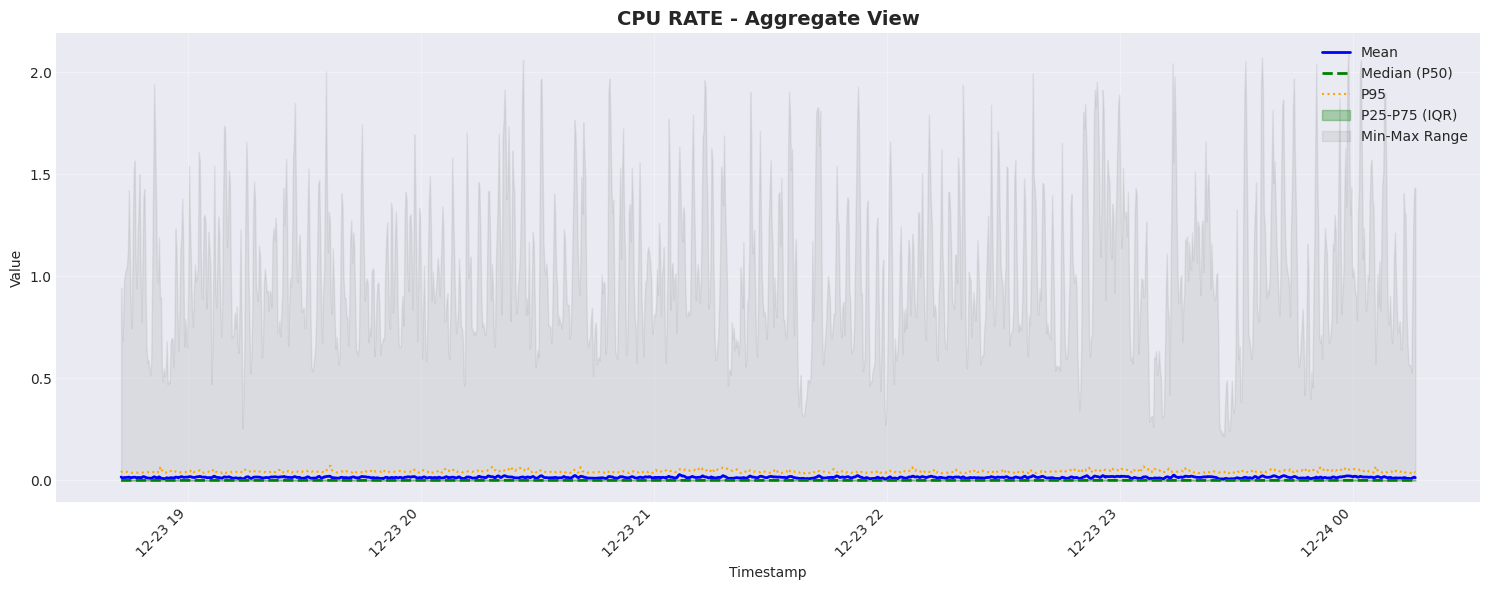

✅ Plotted cpu_rate in aggregate mode


In [97]:
# Configuration: Choose which metric to visualize
METRIC_TO_PLOT = 'cpu_rate'  # Options: 'cpu_rate', 'memory_usage', 'network_transmit_rate', etc.
VIEW_MODE = 'aggregate'      # Options: 'individual' (all containers) or 'aggregate' (cluster-wide)
MAX_CONTAINERS = 10           # Max containers to plot in individual mode

# Define appropriate aggregation per metric type
aggregation_strategy = {
    'network_transmit_rate': 'max',
    'network_receive_rate': 'max',
    'cpu_rate': 'max',
    'memory_usage': 'max',
    'fs_writes_rate': 'max',
    'fs_reads_rate': 'max',
}

# Get the selected metric data
metric_data = DATAFRAMES[METRIC_TO_PLOT]
agg_func = aggregation_strategy[METRIC_TO_PLOT]

# Remove duplicates per container
time_series = metric_data.groupby(['timestamp', 'container_id'])['value'].agg(agg_func)

# Create plot
fig, ax = plt.subplots(figsize=(15, 6))

if VIEW_MODE == 'individual':
    # Get sample of containers
    all_containers = time_series.index.get_level_values('container_id').unique()
    # sample_containers = all_containers.sample(MAX_CONTAINERS)abs
    sample_containers = np.random.choice(all_containers, size=min(MAX_CONTAINERS, len(all_containers)), replace=False)

    print(f"Plotting {len(sample_containers)} of {len(all_containers)} containers")

    # Plot each container separately
    for container_id in sample_containers:
        container_data = time_series.xs(container_id, level='container_id')
        # Shorten container name for legend
        short_name = container_id.split('/')[-1][:20] + '...'
        ax.plot(container_data.index, container_data.values, alpha=0.7, linewidth=1.5, label=short_name)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

elif VIEW_MODE == 'aggregate':
    # Cluster-wide statistics
    # time_stats = time_series.groupby('timestamp').agg(['mean', 'min', 'max', 'median'])
    # ax.plot(time_stats.index, time_stats['mean'], label='Mean', linewidth=2, color='blue')
    # ax.fill_between(time_stats.index, time_stats['min'], time_stats['max'],
    #                  alpha=0.3, label='Min-Max Range', color='blue')
    # ax.legend(loc='upper right')
    time_stats = time_series.groupby('timestamp').agg([
        'mean', 
        'min', 
        'max',
        ('p25', lambda x: x.quantile(0.25)),
        ('p50', lambda x: x.quantile(0.50)),  # median
        ('p75', lambda x: x.quantile(0.75)),
        ('p95', lambda x: x.quantile(0.95))
    ])

    # Plot lines
    ax.plot(time_stats.index, time_stats['mean'], label='Mean', linewidth=2, color='blue')
    ax.plot(time_stats.index, time_stats['p50'], label='Median (P50)', linewidth=2, color='green', linestyle='--')
    ax.plot(time_stats.index, time_stats['p95'], label='P95', linewidth=1.5, color='orange', linestyle=':')

    # Shaded regions
    ax.fill_between(time_stats.index, time_stats['p25'], time_stats['p75'],
                     alpha=0.3, label='P25-P75 (IQR)', color='green')
    ax.fill_between(time_stats.index, time_stats['min'], time_stats['max'],
                     alpha=0.15, label='Min-Max Range', color='gray')

    ax.legend(loc='upper right')

ax.set_title(f'{METRIC_TO_PLOT.upper().replace("_", " ")} - {VIEW_MODE.capitalize()} View',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"✅ Plotted {METRIC_TO_PLOT} in {VIEW_MODE} mode")

## Configurable Metric Visualization with Bokeh

*Interactive*: Pan, zoom, box select

*Y_SCALE config:* Switch between 'linear', 'log', 'sqrt' to see patterns better

*Hover tooltips:* See exact values on mouseover

*Legend interactions:* Click legend items to hide/show lines

*Better for large data:* Bokeh handles time series better than matplotlib


In [133]:
output_notebook()

# Configuration
METRIC_TO_PLOT = 'memory_usage'  # Options: 'cpu_rate', 'memory_usage', 'network_transmit_rate', etc.
VIEW_MODE = 'individual'       # Options: 'individual' (all containers) or 'aggregate' (cluster-wide)
MAX_CONTAINERS = 100          # Max containers to plot in individual mode
Y_SCALE = 'log'            # Options: 'linear', 'log'

# Define appropriate aggregation per metric type
aggregation_strategy = {
    'network_transmit_rate': 'max',
    'network_receive_rate': 'max',
    'cpu_rate': 'max',
    'memory_usage': 'max',
    'fs_writes_rate': 'max',
    'fs_reads_rate': 'max',
}

# Get the selected metric data
metric_data = DATAFRAMES[METRIC_TO_PLOT]
agg_func = aggregation_strategy[METRIC_TO_PLOT]

# Remove duplicates per container
time_series = metric_data.groupby(['timestamp', 'container_id'])['value'].agg(agg_func)

# Create plot
p = figure(
    width=1200,
    height=500,
    x_axis_type='datetime',
    y_axis_type=Y_SCALE,
    title=f'{METRIC_TO_PLOT.upper().replace("_", " ")} - {VIEW_MODE.capitalize()} View',
    tools='pan,wheel_zoom,box_zoom,reset,save',
    toolbar_location='above'
)

if VIEW_MODE == 'individual':
    # Get sample of containers
    all_containers = time_series.index.get_level_values('container_id').unique()
    sample_containers = np.random.choice(
        all_containers,
        size=min(MAX_CONTAINERS, len(all_containers)),
        replace=False
    )
    print(f"Plotting {len(sample_containers)} of {len(all_containers)} containers")

    from bokeh.palettes import Reds256
    if len(sample_containers) <= 256:
        colors = Reds256[:len(sample_containers)][::-1]

    # Plot each container separately
    for idx, container_id in enumerate(sample_containers):
        container_data = time_series.xs(container_id, level='container_id')
        short_name = container_id.split('/')[-1][:20] + '...'

        source = ColumnDataSource(data=dict(
            x=container_data.index.to_numpy(),
            y=container_data.values,
            container=[short_name] * len(container_data)
        ))
        p.line('x', 'y', source=source, legend_label=short_name,
               color=colors[idx % len(colors)], alpha=0.8, line_width=0.5)
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"

elif VIEW_MODE == 'aggregate':
    # Cluster-wide statistics
    time_stats = time_series.groupby('timestamp').agg([
        'mean',
        'min',
        'max',
        ('p25', lambda x: x.quantile(0.25)),
        ('p50', lambda x: x.quantile(0.50)),
        ('p75', lambda x: x.quantile(0.75)),
        ('p95', lambda x: x.quantile(0.95)),
        ('p99', lambda x: x.quantile(0.99))
    ])

    # Create data source
    source = ColumnDataSource(data=dict(
        x=time_stats.index.to_numpy(),
        mean=time_stats['mean'].values,
        p50=time_stats['p50'].values,
        p99=time_stats['p99'].values,
        p95=time_stats['p95'].values,
        p25=time_stats['p25'].values,
        p75=time_stats['p75'].values,
        min=time_stats['min'].values,
        max=time_stats['max'].values
    ))

    # High-contrast colors using color theory
    COLOR_MEAN = '#2E86AB'
    COLOR_MEDIAN = '#06A77D'
    COLOR_P95 = '#F77F00'
    COLOR_P99 = '#D62828'
    COLOR_P25 = '#06A77D'
    COLOR_P75 = '#06A770'
    COLOR_MAX = '#F77F10'

    # Plot lines - reduced thickness
    p.line('x', 'mean', source=source, legend_label='Mean',
           line_width=1, color=COLOR_MEAN, alpha=0.9)
    p.line('x', 'p25', source=source, legend_label='P25',
           line_width=1, color=COLOR_MEDIAN, alpha=0.9)
    p.line('x', 'p50', source=source, legend_label='Median (P50)',
           line_width=1, color=COLOR_MEDIAN, alpha=0.9)
    p.line('x', 'p75', source=source, legend_label='P75',
           line_width=1, color=COLOR_MEDIAN, alpha=0.9)
    p.line('x', 'p95', source=source, legend_label='P95',
           line_width=1, color=COLOR_P95, alpha=0.9)
    p.line('x', 'p99', source=source, legend_label='P99',
           line_width=1, color=COLOR_P99, alpha=0.9)
    p.line('x', 'max', source=source, legend_label='Max',
           line_width=1, color=COLOR_MAX, alpha=0.9)

    p.legend.location = "top_right"
    p.legend.click_policy = "hide"
    p.legend.label_text_font_size = "10pt"

# Styling
p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Value'
p.title.text_font_size = '14pt'
p.xaxis.major_label_orientation = 0.785  # 45 degrees in radians

# Add hover tool with better formatting - fixed for aggregate mode
if VIEW_MODE == 'aggregate':
    hover = HoverTool(tooltips=[
        ('Time', '@x{%F %T}'),
        ('Mean', '@mean{0,0.00}'),
        ('P25', '@p25{0,0.00}'),
        ('Median', '@p50{0,0.00}'),
        ('P75', '@p75{0,0.00}'),
        ('P95', '@p95{0,0.00}'),
        ('P99', '@p99{0,0.00}')
    ], formatters={'@x': 'datetime'})
else:
    hover = HoverTool(tooltips=[
        ('Time', '@x{%F %T}'),
        ('Value', '@y{0,0.00}'),
        ('Container', '@container')
    ], formatters={'@x': 'datetime'})

p.add_tools(hover)

show(p)
print(f"✅ Plotted {METRIC_TO_PLOT} in {VIEW_MODE} mode with {Y_SCALE} scale")

Loading BokehJS ...

Plotting 100 of 910 containers


✅ Plotted memory_usage in individual mode with log scale


## Pattern Detection

Identify patterns such as spikes, periodic behavior, and anomalies.

In [139]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import HoverTool, Span, Band, ColumnDataSource
from bokeh.io import output_notebook


class MetricPatternDetector:
    """Detect patterns in time series metrics with configurable parameters."""
    
    def __init__(self, window_size=20, std_threshold=2.0):
        """
        Initialize pattern detector.
        
        Args:
            window_size: Number of points for rolling window calculations
            std_threshold: Number of std deviations to consider as spike
        """
        self.window_size = window_size
        self.std_threshold = std_threshold
    
    def detect_patterns(self, data, metric_name, aggregate_func='sum'):
        """
        Detect patterns in metric data.
        
        Args:
            data: DataFrame with 'timestamp' and 'value' columns
            metric_name: Name of the metric being analyzed
            aggregate_func: How to aggregate values per timestamp ('sum', 'mean', 'max', etc.)
            
        Returns:
            DataFrame with pattern analysis results
        """
        if len(data) == 0:
            return None
        
        # Aggregate data by timestamp
        agg_func = getattr(data.groupby('timestamp')['value'], aggregate_func)
        ts = agg_func()
        
        # Calculate rolling statistics
        ts_df = pd.DataFrame({
            'value': ts.values,
            'rolling_mean': ts.rolling(window=self.window_size, center=True).mean(),
            'rolling_std': ts.rolling(window=self.window_size, center=True).std()
        }, index=ts.index)
        
        # Calculate confidence bands
        ts_df['upper_band'] = ts_df['rolling_mean'] + self.std_threshold * ts_df['rolling_std']
        ts_df['lower_band'] = ts_df['rolling_mean'] - self.std_threshold * ts_df['rolling_std']
        
        # Detect anomalies (spikes and dips)
        ts_df['spike'] = ts_df['value'] > ts_df['upper_band']
        ts_df['dip'] = ts_df['value'] < ts_df['lower_band']
        ts_df['anomaly'] = ts_df['spike'] | ts_df['dip']
        
        return ts_df
    
    def get_statistics(self, ts_df):
        """Calculate summary statistics."""
        if ts_df is None or len(ts_df) == 0:
            return None
        
        return {
            'total_points': len(ts_df),
            'spikes': ts_df['spike'].sum(),
            'dips': ts_df['dip'].sum(),
            'anomalies': ts_df['anomaly'].sum(),
            'anomaly_rate': 100 * ts_df['anomaly'].sum() / len(ts_df),
            'mean': ts_df['value'].mean(),
            'std': ts_df['value'].std(),
            'cv': ts_df['value'].std() / ts_df['value'].mean() if ts_df['value'].mean() != 0 else np.nan,
            'min': ts_df['value'].min(),
            'max': ts_df['value'].max()
        }
    
    def plot(self, ts_df, metric_name, unit='', width=1200, height=500):
        """
        Create interactive Bokeh plot.
        
        Args:
            ts_df: DataFrame from detect_patterns()
            metric_name: Name of metric for title
            unit: Unit of measurement for y-axis
            width: Plot width in pixels
            height: Plot height in pixels
        """
        if ts_df is None or len(ts_df) == 0:
            print(f"⚠️  No data available for {metric_name}")
            return None
        
        # Prepare data sources
        ts_df = ts_df.copy()
        ts_df['timestamp_dt'] = pd.to_datetime(ts_df.index)
        
        source = ColumnDataSource(ts_df)
        
        # Create figure
        p = figure(
            width=width,
            height=height,
            x_axis_type='datetime',
            title=f'{metric_name.replace("_", " ").title()} Pattern Detection',
            toolbar_location='above',
            tools='pan,wheel_zoom,box_zoom,reset,save'
        )
        
        # Plot confidence band
        band = Band(
            base='timestamp_dt',
            lower='lower_band',
            upper='upper_band',
            source=source,
            fill_alpha=0.2,
            fill_color='gray',
            line_width=0
        )
        p.add_layout(band)
        
        # Plot rolling mean
        p.line(
            'timestamp_dt',
            'rolling_mean',
            source=source,
            line_width=2,
            line_color='blue',
            line_dash='dashed',
            legend_label=f'Rolling Mean ({self.window_size} samples)',
            alpha=0.7
        )
        
        # Plot actual values
        p.line(
            'timestamp_dt',
            'value',
            source=source,
            line_width=2,
            line_color='green',
            legend_label='Actual Value'
        )
        
        # Mark spikes
        spikes = ts_df[ts_df['spike']]
        if len(spikes) > 0:
            spike_source = ColumnDataSource(spikes)
            p.scatter(
                'timestamp_dt',
                'value',
                source=spike_source,
                size=10,
                color='red',
                legend_label=f'Spikes ({len(spikes)})',
                alpha=0.8
            )
        
        # Mark dips
        dips = ts_df[ts_df['dip']]
        if len(dips) > 0:
            dip_source = ColumnDataSource(dips)
            p.scatter(
                'timestamp_dt',
                'value',
                source=dip_source,
                size=10,
                color='orange',
                legend_label=f'Dips ({len(dips)})',
                alpha=0.8
            )
        
        # Add hover tool
        hover = HoverTool(
            tooltips=[
                ('Time', '@timestamp_dt{%F %T}'),
                ('Value', f'@value{{0.0000}}{unit}'),
                ('Mean', f'@rolling_mean{{0.0000}}{unit}'),
                ('Std Dev', f'@rolling_std{{0.0000}}{unit}'),
                ('Spike', '@spike'),
                ('Dip', '@dip')
            ],
            formatters={'@timestamp_dt': 'datetime'},
            mode='vline'
        )
        p.add_tools(hover)
        
        # Style
        y_label = f'{metric_name.replace("_", " ").title()}'
        if unit:
            y_label += f' ({unit})'
        p.yaxis.axis_label = y_label
        p.xaxis.axis_label = 'Time'
        p.legend.location = 'top_right'
        p.legend.click_policy = 'hide'
        
        return p
    
    def analyze_metric(self, data, metric_name, aggregate_func='sum', unit='', print_stats=True):
        """
        Complete analysis pipeline: detect patterns, plot, and print statistics.
        
        Args:
            data: DataFrame with 'timestamp' and 'value' columns
            metric_name: Name of metric
            aggregate_func: Aggregation function
            unit: Unit of measurement
            print_stats: Whether to print statistics
            
        Returns:
            Tuple of (DataFrame with patterns, Bokeh plot, statistics dict)
        """
        print("=" * 80)
        print(f"PATTERN DETECTION: {metric_name.upper()}")
        print("=" * 80)
        
        ts_df = self.detect_patterns(data, metric_name, aggregate_func)
        stats = self.get_statistics(ts_df)
        plot = self.plot(ts_df, metric_name, unit)
        
        if print_stats and stats:
            print(f"\n🔍 Pattern Analysis:")
            print(f"   Total data points: {stats['total_points']:,}")
            print(f"   Spikes detected: {stats['spikes']}")
            print(f"   Dips detected: {stats['dips']}")
            print(f"   Total anomalies: {stats['anomalies']}")
            print(f"   Anomaly rate: {stats['anomaly_rate']:.2f}%")
            print(f"   Mean: {stats['mean']:.4f} {unit}")
            print(f"   Std Dev: {stats['std']:.4f} {unit}")
            print(f"   Range: [{stats['min']:.4f}, {stats['max']:.4f}] {unit}")
            print(f"   Coefficient of Variation: {stats['cv']:.4f}")
        
        if plot:
            show(plot)
        
        return ts_df, plot, stats


# Example usage
if __name__ == "__main__":
    # Assuming DATAFRAMES dict exists from previous code
    detector = MetricPatternDetector(window_size=20, std_threshold=2.0)
    
    # Analyze multiple metrics
    # network_transmit_rate': 'max',
    # 'network_receive_rate': 'max',
    # 'cpu_rate': 'max',
    # 'memory_usage': 'max',
    # 'fs_writes_rate': 'max',
    # 'fs_reads_rate': 'max',
    metrics_config = {
        'cpu_rate': {'aggregate': 'max', 'unit': 'cores'},
        'memory_usage': {'aggregate': 'max', 'unit': 'bytes'},
        'network_transmit_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
        'network_receive_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
        'fs_writes_rate':  {'aggregate': 'max', 'unit': 'TBC'},
        'fs_reads_rate':   {'aggregate': 'max', 'unit': 'TBC'}
    }
    
    for metric_name, config in metrics_config.items():
        if metric_name in DATAFRAMES:
            detector.analyze_metric(
                DATAFRAMES[metric_name],
                metric_name,
                aggregate_func=config['aggregate'],
                unit=config['unit']
            )

PATTERN DETECTION: CPU_RATE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 42
   Dips detected: 1
   Total anomalies: 43
   Anomaly rate: 3.22%
   Mean: 1.0239 cores
   Std Dev: 0.3748 cores
   Range: [0.2164, 2.0867] cores
   Coefficient of Variation: 0.3660


PATTERN DETECTION: MEMORY_USAGE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 0
   Dips detected: 7
   Total anomalies: 7
   Anomaly rate: 0.52%
   Mean: 16746677338.5787 bytes
   Std Dev: 1700272418.0908 bytes
   Range: [3931283456.0000, 17307799552.0000] bytes
   Coefficient of Variation: 0.1015


PATTERN DETECTION: NETWORK_TRANSMIT_RATE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 57
   Dips detected: 11
   Total anomalies: 68
   Anomaly rate: 5.10%
   Mean: 784472.0207 bytes/s
   Std Dev: 58929.2336 bytes/s
   Range: [602826.4676, 1149916.7566] bytes/s
   Coefficient of Variation: 0.0751


PATTERN DETECTION: NETWORK_RECEIVE_RATE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 79
   Dips detected: 0
   Total anomalies: 79
   Anomaly rate: 5.92%
   Mean: 1138642.5518 bytes/s
   Std Dev: 351269.6708 bytes/s
   Range: [621728.3066, 2424064.1769] bytes/s
   Coefficient of Variation: 0.3085


PATTERN DETECTION: FS_WRITES_RATE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 25
   Dips detected: 26
   Total anomalies: 51
   Anomaly rate: 3.82%
   Mean: 10.4317 TBC
   Std Dev: 0.9207 TBC
   Range: [8.4019, 27.8414] TBC
   Coefficient of Variation: 0.0883


PATTERN DETECTION: FS_READS_RATE

🔍 Pattern Analysis:
   Total data points: 1,334
   Spikes detected: 64
   Dips detected: 1
   Total anomalies: 65
   Anomaly rate: 4.87%
   Mean: 72.5706 TBC
   Std Dev: 39.6412 TBC
   Range: [38.4702, 258.5286] TBC
   Coefficient of Variation: 0.5462


## Correlation Analysis

Analyze correlations between different metrics and containers.

In [ ]:
class MetricCorrelationAnalyzer:
    """Analyze correlations between time series metrics."""
    def __init__(self, metrics_config=None):
        """
        Initialize correlation analyzer.
        Args:
            metrics_config: Dict mapping metric names to config (aggregate, unit)
        """
        self.metrics_config = metrics_config or {
            'cpu_rate': {'aggregate': 'max', 'unit': 'cores'},
            'memory_usage': {'aggregate': 'max', 'unit': 'bytes'},
            'network_transmit_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
            'network_receive_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
            'fs_writes_rate': {'aggregate': 'max', 'unit': 'ops/s'},
            'fs_reads_rate': {'aggregate': 'max', 'unit': 'ops/s'}
        }

    def prepare_pivot_data(self, dataframes_dict, include_containers=True):
        """
        Prepare data for correlation analysis by pivoting metrics into columns.
        Args:
            dataframes_dict: Dict mapping metric names to DataFrames with columns:
                           timestamp, value, [container_id/container_labels]
            include_containers: If True and container_id exists, create separate series per container
        Returns:
            DataFrame with timestamps as index and metric series as columns
        """
        pivot_data = {}

        for metric_name, metric_df in dataframes_dict.items():
            if metric_df is None or len(metric_df) == 0:
                continue

            config = self.metrics_config.get(metric_name, {'aggregate': 'mean'})
            agg_func = config.get('aggregate', 'mean')

            if include_containers and 'container_id' in metric_df.columns:
                # Create separate series for each container
                for container in metric_df['container_id'].unique():
                    container_df = metric_df[metric_df['container_id'] == container]
                    agg_method = getattr(container_df.groupby('timestamp')['value'], agg_func)
                    ts = agg_method()
                    # Use short container ID (last 12 chars) for readability
                    short_id = container.split('/')[-1][-12:] if '/' in container else container[-12:]
                    pivot_data[f'{metric_name}_{short_id}'] = ts
            else:
                # Aggregate across all containers
                agg_method = getattr(metric_df.groupby('timestamp')['value'], agg_func)
                ts = agg_method()
                pivot_data[metric_name] = ts

        if not pivot_data:
            return None
        # Combine into single DataFrame and forward-fill missing values
        corr_df = pd.DataFrame(pivot_data)
        corr_df = corr_df.fillna(method='ffill').fillna(method='bfill')

        return corr_df

    def calculate_correlation(self, corr_df, method='pearson'):
        """
        Calculate correlation matrix.

        Args:
            corr_df: DataFrame from prepare_pivot_data()
            method: 'pearson', 'spearman', or 'kendall'

        Returns:
            Correlation matrix DataFrame
        """
        if corr_df is None or len(corr_df.columns) < 2:
            return None

        return corr_df.corr(method=method)

    def find_high_correlations(self, corr_matrix, threshold=0.7):
        """
        Find pairs with high correlation.
        Args:
            corr_matrix: Correlation matrix from calculate_correlation()
            threshold: Minimum absolute correlation value
        Returns:
            List of tuples: (metric1, metric2, correlation_value)
        """
        if corr_matrix is None:
            return []

        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > threshold:
                    high_corr.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_val
                    ))

        # Sort by absolute correlation value
        high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
        return high_corr

    def plot_correlation_heatmap(self, corr_matrix, width=900, height=800):
        """
        Create interactive Bokeh heatmap of correlations.
        Args:
            corr_matrix: Correlation matrix DataFrame
            width: Plot width in pixels
            height: Plot height in pixels
        Returns
            Bokeh figure
        """
        if corr_matrix is None or corr_matrix.empty:
            print("⚠️  No correlation data to plot")
            return None

        # Prepare data for heatmap
        corr_matrix = corr_matrix.round(3)
        metrics = list(corr_matrix.columns)

        # Create data in format needed for Bokeh rect glyph
        data = {
            'x': [],
            'y': [],
            'correlation': [],
            'x_name': [],
            'y_name': []
        }

        for i, row_name in enumerate(metrics):
            for j, col_name in enumerate(metrics):
                data['x'].append(j)
                data['y'].append(i)
                data['correlation'].append(corr_matrix.loc[row_name, col_name])
                data['x_name'].append(col_name)
                data['y_name'].append(row_name)

        # Color mapper
        colors = list(reversed(RdYlBu11))
        mapper = LinearColorMapper(palette=colors, low=-1, high=1)

        # Create figure
        p = figure(
            width=width,
            height=height,
            x_range=metrics,
            y_range=list(reversed(metrics)),
            toolbar_location='above',
            tools='pan,wheel_zoom,box_zoom,reset,save,hover',
            title='Metric Correlation Heatmap',
            x_axis_location='below'
        )

        # Draw rectangles
        p.rect(
            x='x',
            y='y',
            width=1,
            height=1,
            source=data,
            fill_color=transform('correlation', mapper),
            line_color=None
        )

        # Add color bar
        color_bar = ColorBar(
            color_mapper=mapper,
            ticker=BasicTicker(desired_num_ticks=11),
            label_standoff=12,
            border_line_color=None,
            location=(0, 0)
        )
        p.add_layout(color_bar, 'right')

        # Configure hover tool
        hover = p.select_one(HoverTool)
        hover.tooltips = [
            ('Metrics', '@y_name ↔ @x_name'),
            ('Correlation', '@correlation{0.000}')
        ]

        # Style
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size = '10pt'
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = 'vertical'

        return p

    def analyze(self, dataframes_dict, include_containers=True, corr_threshold=0.7, 
                corr_method='pearson', print_stats=True):
        """
        Complete correlation analysis pipeline.

        Args:
            dataframes_dict: Dict mapping metric names to DataFrames
            include_containers: Whether to separate by container
            corr_threshold: Threshold for reporting high correlations
            corr_method: Correlation method ('pearson', 'spearman', 'kendall')
            print_stats: Whether to print statistics

        Returns:
            Tuple of (correlation matrix, Bokeh plot, high correlations list)
        """
        print("=" * 80)
        print("CORRELATION ANALYSIS")
        print("=" * 80)

        # Prepare data
        corr_df = self.prepare_pivot_data(dataframes_dict, include_containers)

        if corr_df is None or len(corr_df.columns) < 2:
            print("⚠️  Insufficient data for correlation analysis")
            return None, None, []

        # Calculate correlations
        corr_matrix = self.calculate_correlation(corr_df, method=corr_method)

        # Find high correlations
        high_corr = self.find_high_correlations(corr_matrix, threshold=corr_threshold)

        # Create plot
        plot = self.plot_correlation_heatmap(corr_matrix)

        # Print results
        if print_stats:
            print(f"\n📊 Analysis Summary:")
            print(f"   Total metrics/series: {len(corr_matrix.columns)}")
            print(f"   Correlation method: {corr_method}")
            print(f"   Data points per series: {len(corr_df)}")

            if high_corr:
                print(f"\n🔗 High Correlations (|r| > {corr_threshold}):")
                for metric1, metric2, corr_val in high_corr:
                    direction = "+" if corr_val > 0 else "-"
                    print(f"   {metric1:50s} <-> {metric2:50s}: {direction}{abs(corr_val):5.3f}")
            else:
                print(f"\n   No correlations found above threshold {corr_threshold}")

            # Additional statistics
            off_diag = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
            print(f"\n📈 Correlation Statistics:")
            print(f"   Mean correlation: {np.mean(off_diag):.3f}")
            print(f"   Median correlation: {np.median(off_diag):.3f}")
            print(f"   Max correlation: {np.max(off_diag):.3f}")
            print(f"   Min correlation: {np.min(off_diag):.3f}")

        if plot:
            show(plot)

        return corr_matrix, plot, high_corr


# Example usage
if __name__ == "__main__":
    # Configuration
    metrics_config = {
        'cpu_rate': {'aggregate': 'max', 'unit': 'cores'},
        'memory_usage': {'aggregate': 'max', 'unit': 'bytes'},
        'network_transmit_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
        'network_receive_rate': {'aggregate': 'max', 'unit': 'bytes/s'},
        'fs_writes_rate': {'aggregate': 'max', 'unit': 'ops/s'},
        'fs_reads_rate': {'aggregate': 'max', 'unit': 'ops/s'}
    }
    # Assuming DATAFRAMES dict exists from previous code
    # DATAFRAMES is a dict: {'cpu_rate': df1, 'memory_usage': df2, ...}
    # Each df has columns: timestamp, container_labels, value, container_id
    analyzer = MetricCorrelationAnalyzer(metrics_config)

    # Run analysis
    corr_matrix, plot, high_corr = analyzer.analyze(
        DATAFRAMES,
        include_containers=True,  # Set True to separate by container
        corr_threshold=0.7,
        corr_method='pearson'
    )

    # Optional: Export correlation matrix
    if corr_matrix is not None:
        corr_matrix.to_csv('correlation_matrix.csv')

In [ ]:
### Spearman Correlation

In [ ]:
# pearson', 'spearman', or 'kendall'
analyzer = MetricCorrelationAnalyzer(metrics_config)
corr_matrix, plot, high_corr = analyzer.analyze(DATAFRAMES, corr_threshold=0.7, corr_method='spearman', include_containers=False)

In [ ]:
### Kendal Correlation

In [ ]:
analyzer = MetricCorrelationAnalyzer(metrics_config)
corr_matrix, plot, high_corr = analyzer.analyze(DATAFRAMES, corr_threshold=0.7, corr_method='kendall', include_containers=False)